# Model and Dataset Evaluation

This notebook demonstrates how to load and evaluate a model on a given dataset. It includes:

1. Parameter configuration
2. Data loading (both the dataset and any relevant AnnData objects)
3. Generating embeddings via a model
4. Visualizing embeddings with UMAP
5. Pairwise embedding analysis (e.g., similarity)
6. Metrics computation (e.g., scibEvaluator)
7. Annotation and zero-shot classification

You can adapt the parameters at the top to switch between different models and datasets.

In [1]:
import sys

print(sys.path)

['/Users/mengerj/.local/share/uv/python/cpython-3.12.9-macos-aarch64-none/lib/python312.zip', '/Users/mengerj/.local/share/uv/python/cpython-3.12.9-macos-aarch64-none/lib/python3.12', '/Users/mengerj/.local/share/uv/python/cpython-3.12.9-macos-aarch64-none/lib/python3.12/lib-dynload', '', '/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages', '/Users/mengerj/repos/mmcontext/src']


In [2]:
%load_ext autoreload
%autoreload 2

## 1. Imports and Configuration

In [6]:
import anndata
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from mmcontext.eval import evaluate_annotation_accuracy, scibEvaluator, zero_shot_classification_roc
from mmcontext.eval.query_annotate import OmicsQueryAnnotator
from mmcontext.eval.utils import create_emb_pair_dataframe
from mmcontext.file_utils import load_test_adata_from_hf_dataset, subset_dataset_by_chunk
from mmcontext.pl import plot_umap, visualize_embedding_clusters
from mmcontext.pl.plotting import plot_embedding_similarity, plot_grouped_bar_chart, plot_query_scores_umap

# mmcontext imports
from mmcontext.utils import consolidate_low_frequency_categories, setup_logging

logger = setup_logging()


############################################
#           CONFIGURABLE PARAMETERS       #
############################################

SAVE_RESULTS = False  # Optionally toggle saving results
SAVE_FIGURES = False  # Optionally toggle saving figures

DATA_NAME = "cellxgene_35k"
# MODEL_NAME = f"jo-mengr/mmcontext_{DATA_NAME}_sample_tokens_celltype"  # Example model name
MODEL_NAME = "jo-mengr/cg_35k_contrastive_loss_cell_type_NeuML_pubmedbert-base-embeddings_geneformer"
DATASET_NAME = "cellxgene_pseudo_bulk_35k_pairs_cell_type"  # Example dataset name

# These keys can be adapted to your AnnData
BATCH_KEY = "dataset_title"
LABEL_KEY = "cell_type"  # The column used for bio labels
# Additional keys for scibEvaluator
EMBEDDING_KEYS = [
    "mmcontext_emb",
    "mmcontext_text_emb",
    "text_emb_original",
    "X_hvg",
]

# Zero-shot classification function parameters
ZERO_SHOT_LABEL_KEY = LABEL_KEY
ZERO_SHOT_EMB_KEY = "mmcontext_emb"
ZERO_SHOT_TEXT_TEMPLATE = "A sample of {} from a healthy individual"  # "A {} from human bone marrow"  # "A sample of {} from a healthy individual"

logger.info("Configuration parameters set.")

2025-05-26 16:14:23,011 - root - INFO - Configuration parameters set.


## 2. Data Loading

In [7]:
logger.info("Loading dataset from HuggingFace...")
dataset = load_dataset(f"jo-mengr/{DATASET_NAME}", download_mode="force_redownload")

logger.info("Splitting to test subset...")
test_dataset_full = dataset["train"]

logger.info("Loading model...")
model = SentenceTransformer(MODEL_NAME)

logger.info("Loading AnnData from dataset...")
adata, local_path = load_test_adata_from_hf_dataset(
    test_dataset_full, save_dir=f"../../data/from_nxtcloud/test/{DATA_NAME}"
)

logger.info("Subsetting dataset to samples in the current adata chunk...")
adata, test_dataset_sub = subset_dataset_by_chunk(adata, test_dataset_full)

logger.info("Ensuring batch_key is categorical...")
adata.obs[BATCH_KEY] = adata.obs[BATCH_KEY].astype("category")

logger.info("Data loading complete.")
adata

2025-05-26 16:14:25,909 - root - INFO - Loading dataset from HuggingFace...
Generating val split: 100%|██████████| 5754/5754 [00:00<00:00, 1994547.54 examples/s]
2025-05-26 16:14:28,681 - root - INFO - Splitting to test subset...
2025-05-26 16:14:28,682 - root - INFO - Loading model...
2025-05-26 16:14:28,683 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-05-26 16:14:28,683 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: jo-mengr/cg_35k_contrastive_loss_cell_type_NeuML_pubmedbert-base-embeddings_geneformer
2025-05-26 16:14:33,784 - mmcontext.models.mmcontextencoder - WARNING - Loaded encoder was registered for 'geneformer' data. Call register_initial_embeddings() with compatible data before using it.
2025-05-26 16:14:33,939 - root - INFO - Loading AnnData from dataset...
2025-05-26 16:14:33,963 - mmcontext.file_utils - INFO - Found 7 unique share links across ['test'] splits
2025-05-26 16:14:33,964 - mmco

AnnData object with n_obs × n_vars = 4572 × 13254
    obs: 'age', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'cluster_name', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'lobe', 'organism', 'organism_ontology_term_id', 'orig.ident', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'based_on_n_cells', 'abstract', 'dataset_title', 'Sort_id', 'celltype_annotation', 'is_maternal_contaminant', 'original_pub', 'predicted_doublets', 'sample', 'sample_long', 'scvi_clusters', 'Age', 'Amyloid', 'Braak', 'Cell.Types', 'PMI', 'RIN', 'SORT', 'Sample.ID', 'dissection', 'roi', 'sample_id', 'supercluster_term', 'batch', 'cell_cycle', 'cell_description', 'BMI', 'cds', 'donor_region', 'group', 'hash_cluster', 'hash_label', 'hashed', 'lineage', 'pct_counts_hb', 'phase', 'treatment', 'type', '

In [8]:
# If the dataset has "pairs" in the same, filter the label column for == 1.0
if "pairs" in DATASET_NAME:
    test_dataset_sub = test_dataset_sub.filter(lambda x: x["label"] == 1.0)

Filter: 100%|██████████| 9144/9144 [00:00<00:00, 102910.58 examples/s]


In [15]:
import json

sample_ids = test_dataset_sub["sample_idx"]
adata_ids = adata.obs.index.values.tolist()
assert sample_ids == adata_ids, "Sample IDs do not match between HuggingFace and AnnData"

In [10]:
token_df = model[0].get_initial_embeddings(test_dataset_sub, layer_key="X_geneformer")

2025-05-26 16:14:55,204 - mmcontext.file_utils - INFO - Found 1 unique share links across [NamedSplit('train')] splits
Download: 100%|██████████| 1/1 [00:00<00:00, 6543.38file/s]
2025-05-26 16:14:55,214 - mmcontext.file_utils - INFO - Reading /Users/mengerj/repos/mmcontext/data/downloaded_chunks/chunk_0.zarr
2025-05-26 16:14:55,873 - mmcontext.file_utils - INFO - Built DataFrame with 4572 rows × 512-dim embeddings
2025-05-26 16:14:55,883 - mmcontext.models.mmcontextencoder - INFO - Combined embedding DataFrame shape: (4572, 3)


Use the returned DataFrame to register the embeddings with `register_initial_embeddings()`.


In [11]:
model[0].register_initial_embeddings(token_df, data_origin="geneformer")

2025-05-26 16:15:06,502 - mmcontext.models.omicsencoder - INFO - Loaded embedding matrix with shape (4573, 512)
2025-05-26 16:15:06,502 - mmcontext.models.mmcontextencoder - INFO - Registered 4573 new numeric samples (total 4573). ≈0.009 GiB added. (Assuming float32 precision.)


In [12]:
logger.info("Add the prexif to the dataset")
test_dataset = model[0].prefix_ds(test_dataset_sub, cell_sentences_cols=["cell_sentence_1"])

2025-05-26 16:15:07,751 - root - INFO - Add the prexif to the dataset
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Prefixing cell_sentence_1: 100%|██████████| 4572/4572 [00:00<00:00, 77322.46 examples/s]


## 3. Generate Embeddings

We generate:

- `mmcontext_emb` from the omics data
- `mmcontext_text_emb` from the text annotation

In [13]:
logger.info("Generating omics embeddings...")
omics_embeddings = model.encode(test_dataset["sentence_1"])

2025-05-26 16:15:12,702 - root - INFO - Generating omics embeddings...
Batches: 100%|██████████| 143/143 [00:00<00:00, 289.19it/s]


In [14]:
model[0].text_encoder_name

'prajjwal1/bert-tiny'

In [16]:
logger.info("Generating text embeddings with pre-trained multi-modal model...")
text_annotations = adata.obs[LABEL_KEY].values.tolist()  # test_dataset["caption"]
text_embeddings = model.encode(text_annotations)
logger.info("Generating text embeddings with original text model...")
text_encoder_name = model[0].text_encoder_name
text_model = SentenceTransformer(text_encoder_name)
text_embeddings_original = text_model.encode(text_annotations)
logger.info("Embedding generation complete.")

2025-05-26 16:15:39,809 - root - INFO - Generating text embeddings with pre-trained multi-modal model...
Batches: 100%|██████████| 143/143 [00:01<00:00, 87.67it/s] 
2025-05-26 16:15:41,450 - root - INFO - Generating text embeddings with original text model...
2025-05-26 16:15:41,451 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-05-26 16:15:41,452 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: prajjwal1/bert-tiny
2025-05-26 16:15:41,576 - sentence_transformers.SentenceTransformer - WARNING - No sentence-transformers model found with name prajjwal1/bert-tiny. Creating a new one with mean pooling.
Batches: 100%|██████████| 143/143 [00:00<00:00, 221.75it/s]
2025-05-26 16:15:43,481 - root - INFO - Embedding generation complete.


In [17]:
logger.info("Storing embeddings in AnnData...")
adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["mmcontext_text_emb"] = text_embeddings
adata.obsm["text_emb_original"] = text_embeddings_original

2025-05-26 16:15:44,651 - root - INFO - Storing embeddings in AnnData...


In [43]:
import scanpy as sc

# perform leiden clustering
emb_key = "X_pca"
sc.pp.neighbors(adata, n_neighbors=30, use_rep=emb_key)
sc.tl.leiden(adata, resolution=0.5)
adata.obs[f"leiden_{emb_key}"] = adata.obs["leiden"]

/var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/ipykernel_12868/198446673.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


In [10]:
# get index of cells that are from blood and 10x 3' v2
# index_met = adata.obs["cell_type"] == "neuron"
# index_met = index_met & (adata.obs["assay"] == "10x 3' v2")
# adata_neuron = adata[index_met].copy()

## 4. UMAP Visualization

Here, we visualize one of the embeddings (e.g., `mmcontext_text_emb`) with UMAP. We also remove low-frequency categories for better clarity in the plot.

2025-05-26 16:16:15,354 - root - INFO - Consolidating low-frequency categories...
2025-05-26 16:16:15,550 - root - INFO - Plotting UMAP...
2025-05-26 16:16:15,550 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-05-26 16:16:15,551 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


<Figure size 800x800 with 0 Axes>

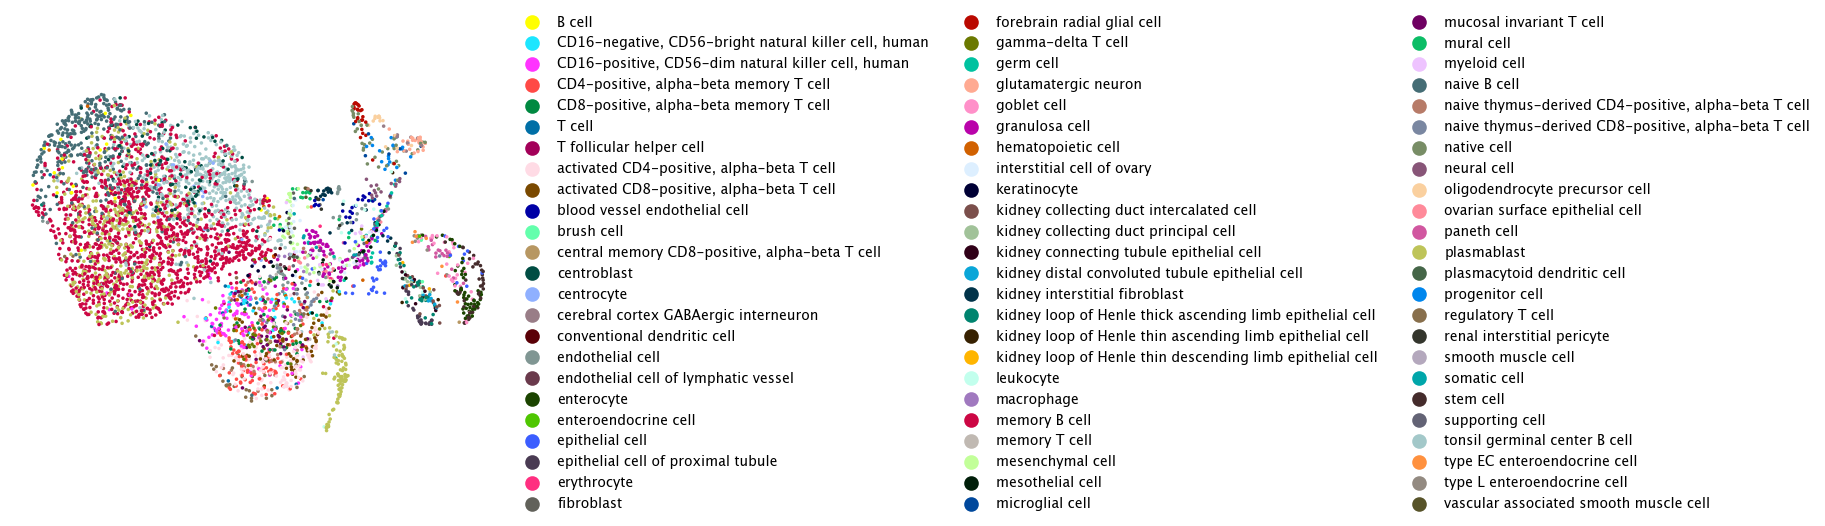

2025-05-26 16:16:19,517 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [20]:
logger.info("Consolidating low-frequency categories...")
# LABEL_KEY = BATCH_KEY
adata_cut = adata.copy()
LABEL_KEY = "cell_type"
adata_cut = consolidate_low_frequency_categories(adata_cut, [LABEL_KEY], threshold=1, remove=True)

# The color_key can be changed to anything in adata.obs, e.g. BATCH_KEY or LABEL_KEY.
color_key = LABEL_KEY

logger.info("Plotting UMAP...")
plot_umap(
    adata_cut,
    color_key=color_key,
    embedding_key="mmcontext_emb",
    title="",
    # legend_loc=None,
    save_plot=False,
    save_format="svg",
    save_dir=".",
)

## 5. Classification accuracy

In [21]:
from mmcontext.eval.utils import LabelKind, LabelSpec

E1 = omics_embeddings
E2 = text_embeddings
y = adata.obs[LABEL_KEY].values.tolist()
label_spec = LabelSpec(name="cell_type", kind=LabelKind.BIO)

In [22]:
from mmcontext.eval.registry import get as get_evaluator

# from mmcontext.eval.label_similarity import LabelSimilarity

ev = get_evaluator("LabelSimilarity")()
result = ev.compute(
    E1,
    emb2=E2,
    labels=y,
    label_kind=label_spec.kind,  # evaluators may ignore
    label_key=label_spec.name,  # evaluators may ignore
)

In [23]:
result

B cell/auc: 0.2086
CD16-negative, CD56-bright natural killer cell, human/auc: 0.6011
CD16-positive, CD56-dim natural killer cell, human/auc: 0.4421
CD4-positive, alpha-beta memory T cell/auc: 0.4371
CD8-positive, alpha-beta memory T cell/auc: 0.6238
T cell/auc: 0.4047
T follicular helper cell/auc: 0.7918
activated CD4-positive, alpha-beta T cell/auc: 0.5732
activated CD8-positive, alpha-beta T cell/auc: 0.6891
blood vessel endothelial cell/auc: 0.9461
brush cell/auc: 0.9396
central memory CD8-positive, alpha-beta T cell/auc: 0.4145
centroblast/auc: 0.5901
centrocyte/auc: 0.6624
cerebral cortex GABAergic interneuron/auc: 0.8104
conventional dendritic cell/auc: 0.2618
endothelial cell/auc: 0.6069
endothelial cell of lymphatic vessel/auc: 0.2501
enterocyte/auc: 0.4705
enteroendocrine cell/auc: 0.6624
epithelial cell/auc: 0.8151
epithelial cell of proximal tubule/auc: 0.7760
erythrocyte/auc: 0.9661
fibroblast/auc: 0.3889
forebrain radial glial cell/auc: 0.3913
gamma-delta T cell/auc: 0.550

In [24]:
from pathlib import Path

plot_dir = Path("eval/LabelSimilarity")
plot_dir.mkdir(parents=True, exist_ok=True)
ev.plot(
    E1,
    out_dir=plot_dir,
    emb2=E2,
    labels=y,  # ground-truth for *this* label column
    label_kind=label_spec.kind,  # "bio"  or  "batch"
    label_key=label_spec.name,  # column name (e.g. "celltype")
)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 600x600 with 0 Axes>

## 5. Pairwise Embedding Analysis

We use `create_emb_pair_dataframe` to create a paired DataFrame of two embeddings (omics vs text). Then:

- `visualize_embedding_clusters` to see how clusters form in a joint space.
- `plot_embedding_similarity` to examine similarity distributions for subsets.

2025-03-06 14:31:25,842 - root - INFO - Creating embedding pair dataframe...
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[label_key] = adata.obs[label_key][sampled_indices[idx]]
2025-03-06 14:31:25,855 - mmcontext.eval.utils - INFO - Created DataFrame with 400 rows (200 samples × 2 modalities)
2025-03-06 14:31:25,857 - root - INFO - Visualizing embedding clusters with UMAP...
2025-03-06 14:31:25,858 - mmcontext.pl.plotting - INFO - Applying UMAP to subset of size=20 with metric=cosine...
/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


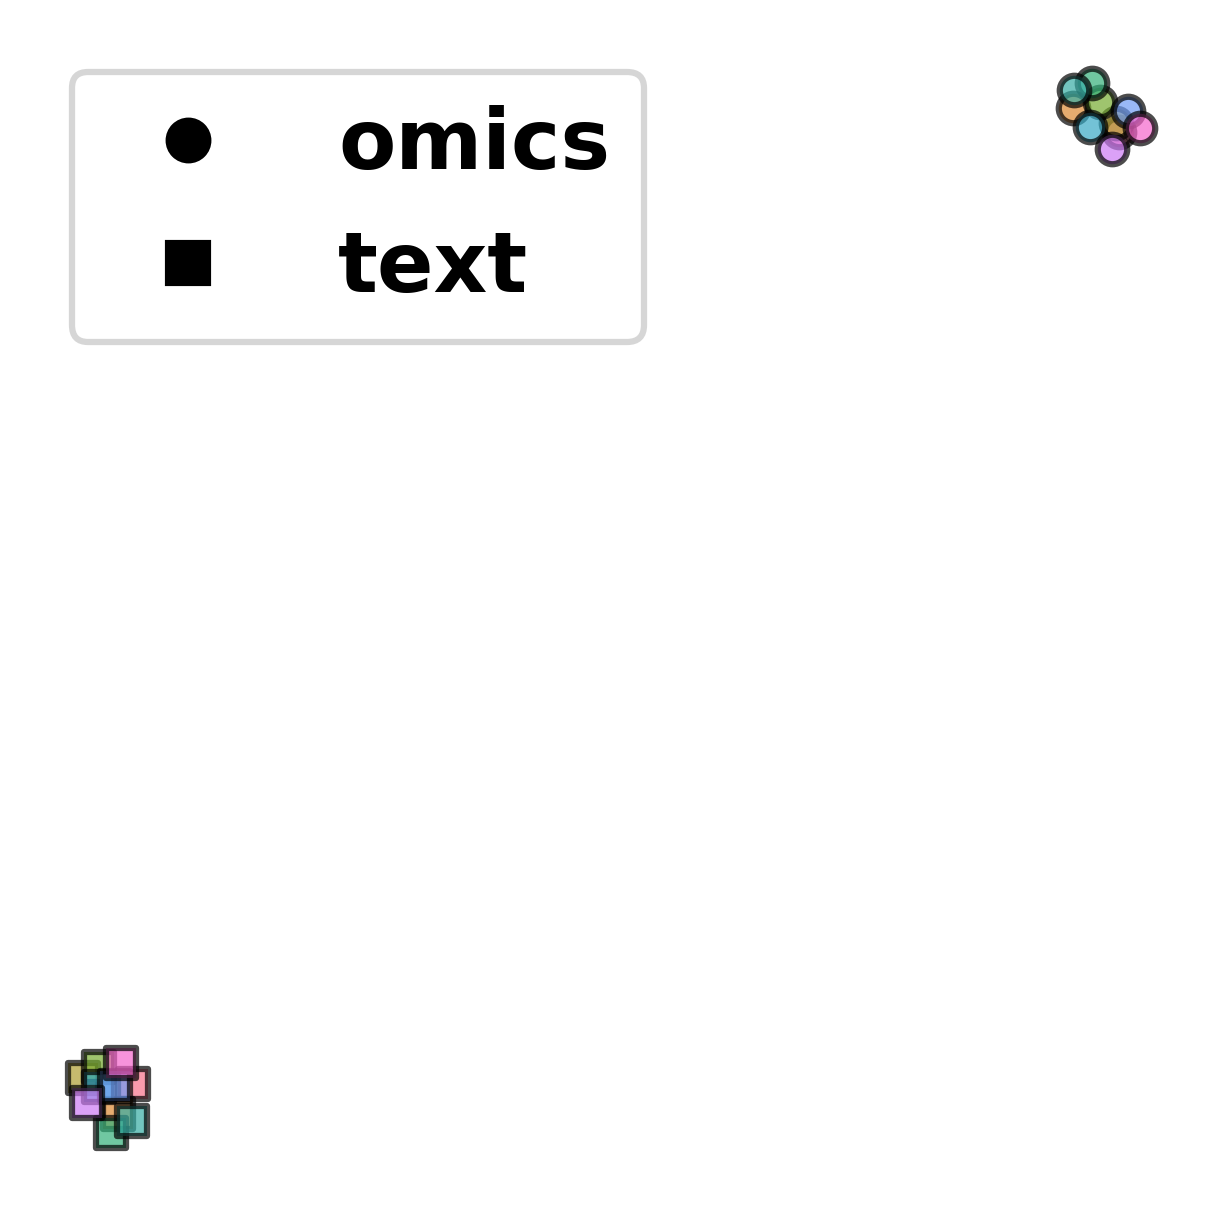

2025-03-06 14:31:26,796 - mmcontext.pl.plotting - INFO - Displayed embedding clusters interactively.


In [21]:
logger.info("Creating embedding pair dataframe...")
embedding_dict = {"omics": "mmcontext_emb", "text": "mmcontext_text_emb"}

emb_pair_df = create_emb_pair_dataframe(
    adata,
    embedding_dict,
    subset_size=200,
    label_keys=[BATCH_KEY, LABEL_KEY],
)

logger.info("Visualizing embedding clusters with UMAP...")
visualize_embedding_clusters(
    emb_pair_df,
    method="umap",
    metric="cosine",
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    n_samples=10,
    legend_fontsize=20,
    figsize=(5, 5),
    save_format="svg",
    save_plot=False,
    save_path="joint_embs_trained",
)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("emb_clusters.png", dpi=150)
    logger.info("Embedding clusters plot saved to emb_clusters.png")

In [22]:
from mmcontext.eval.embedding_alignment import evaluate_modality_alignment

modality_gap_irrelevant_score, full_comparison_score = evaluate_modality_alignment(emb_pair_df)

2025-03-06 14:31:30,633 - mmcontext.eval.embedding_alignment - INFO - Starting modality alignment evaluation.
2025-03-06 14:31:30,871 - mmcontext.eval.embedding_alignment - INFO - Modality-gap-irrelevant score: 0.568635
2025-03-06 14:31:30,872 - mmcontext.eval.embedding_alignment - INFO - Full-comparison score: 0.366150


2025-03-06 13:36:27,251 - root - INFO - Plot embedding similarity with subset=10...


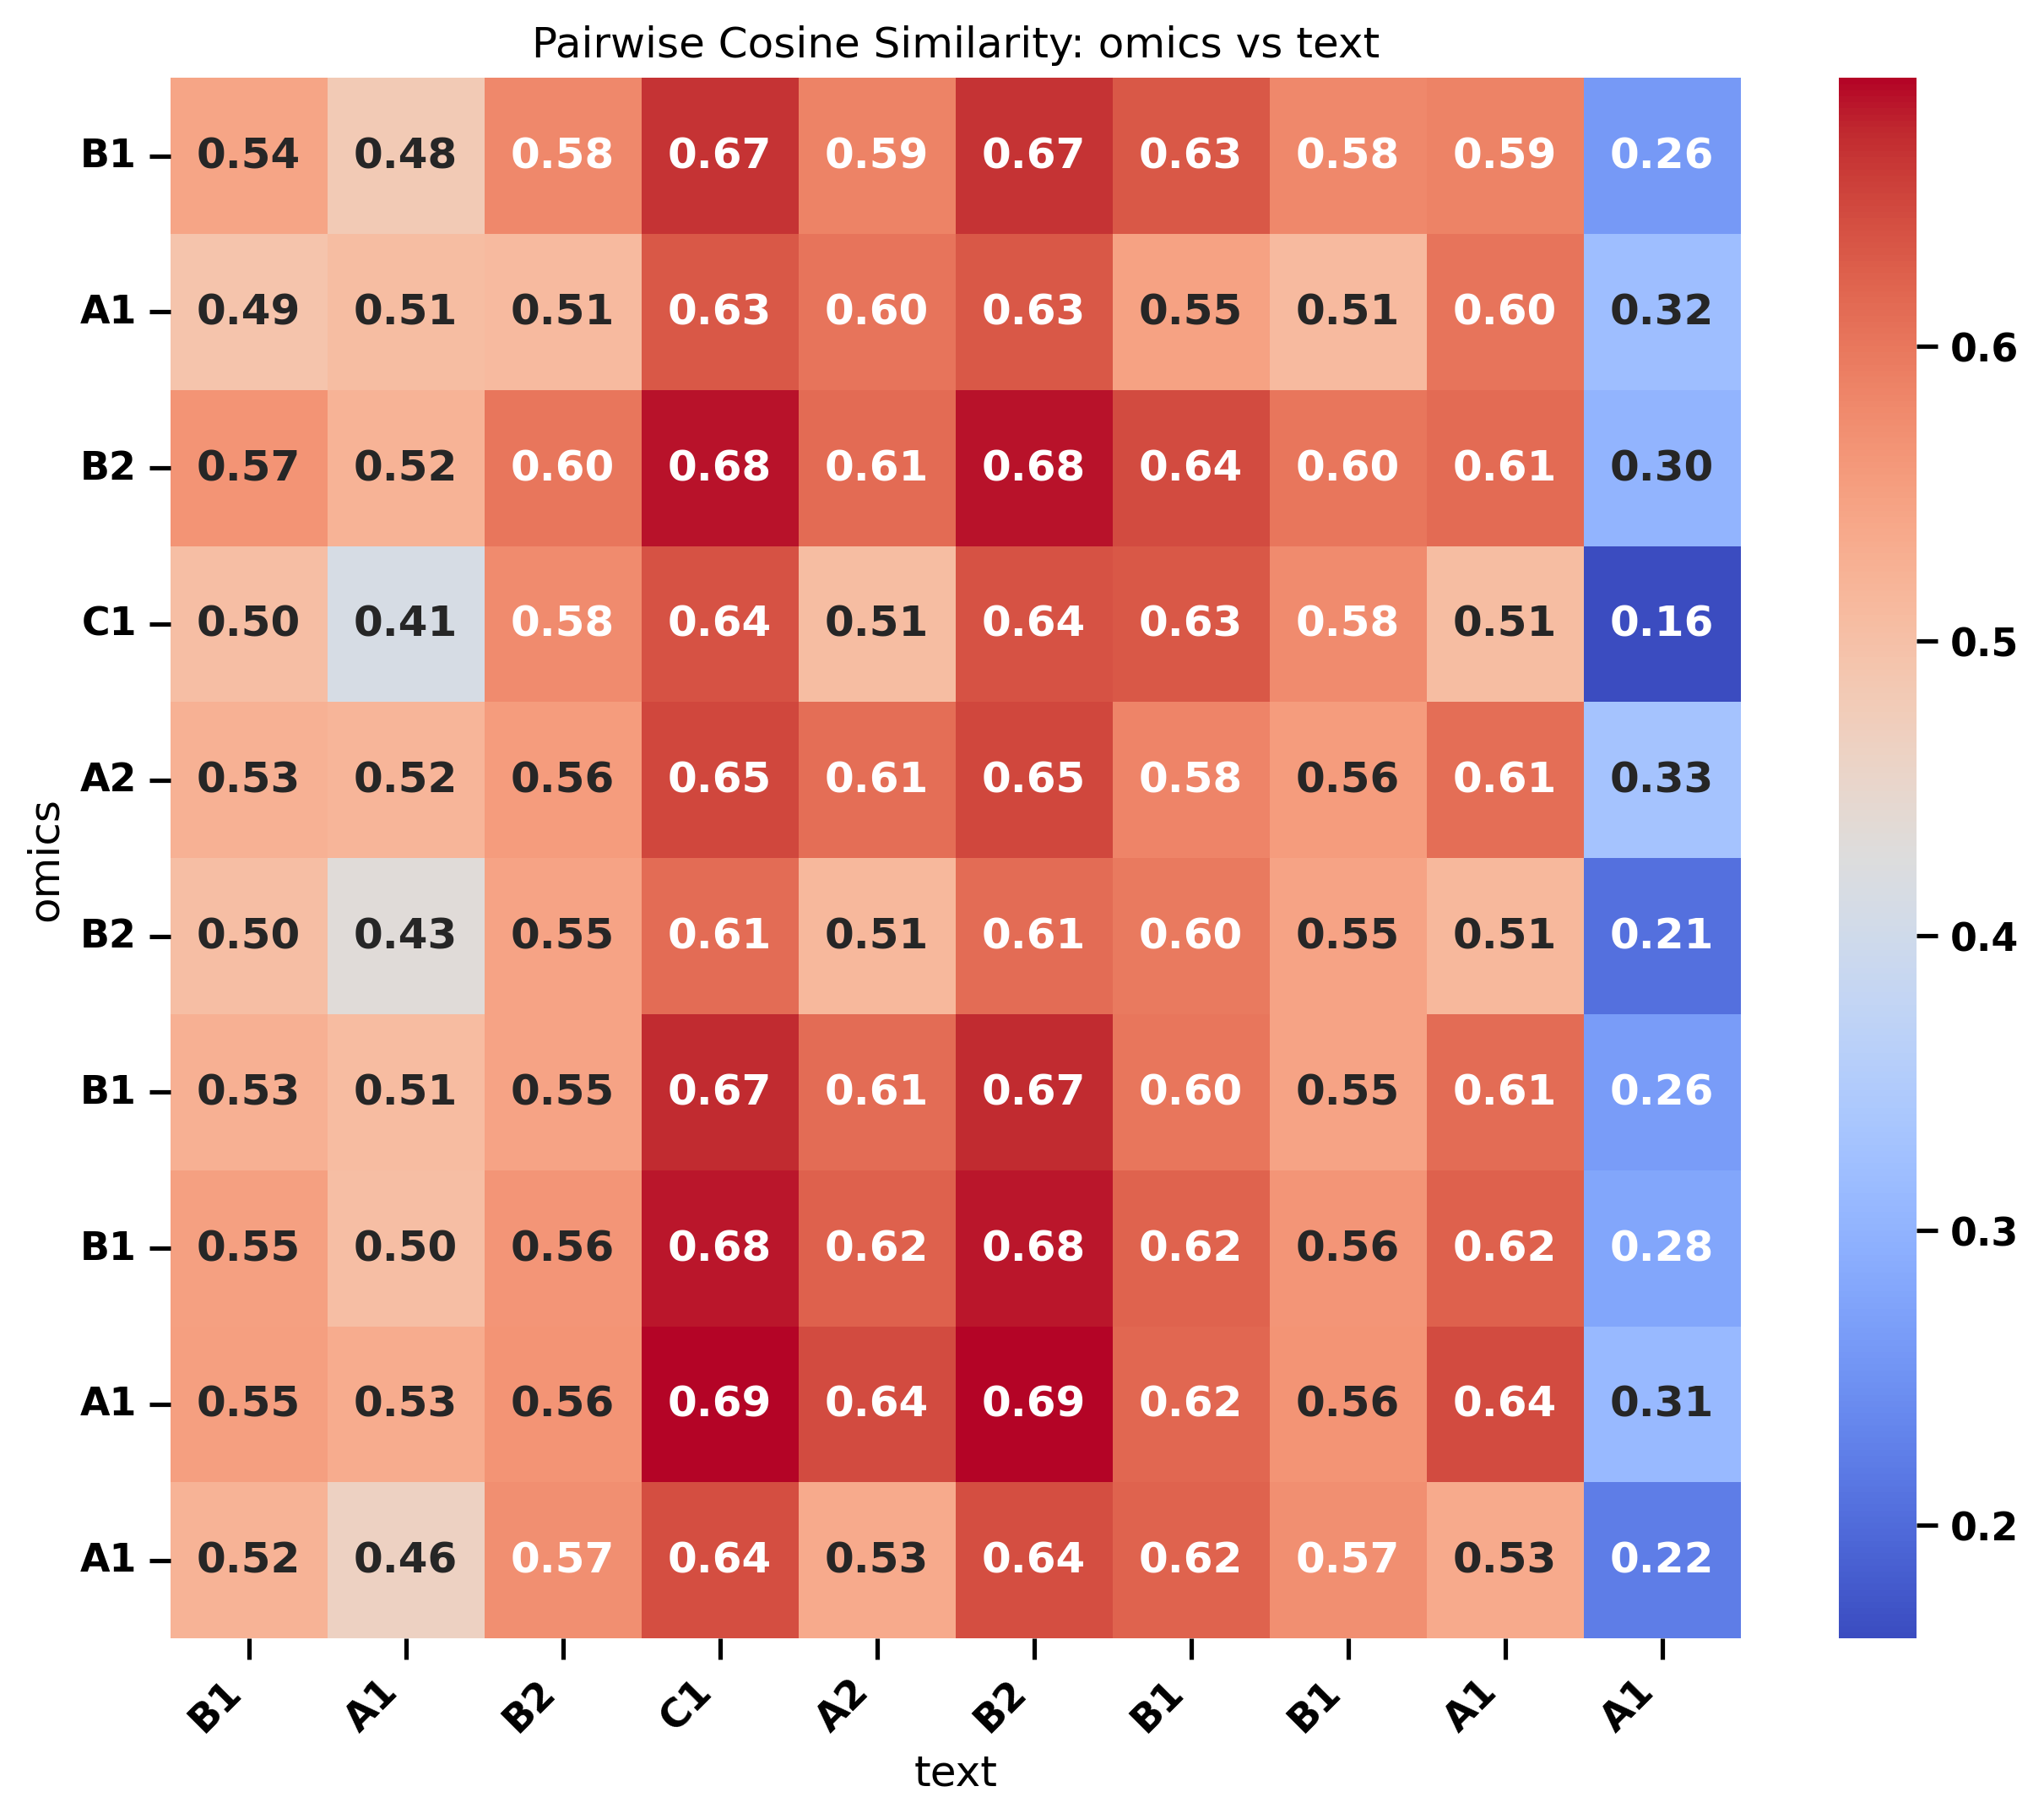

2025-03-06 13:36:27,387 - root - INFO - Plot embedding similarity with subset=10 using cell_type...


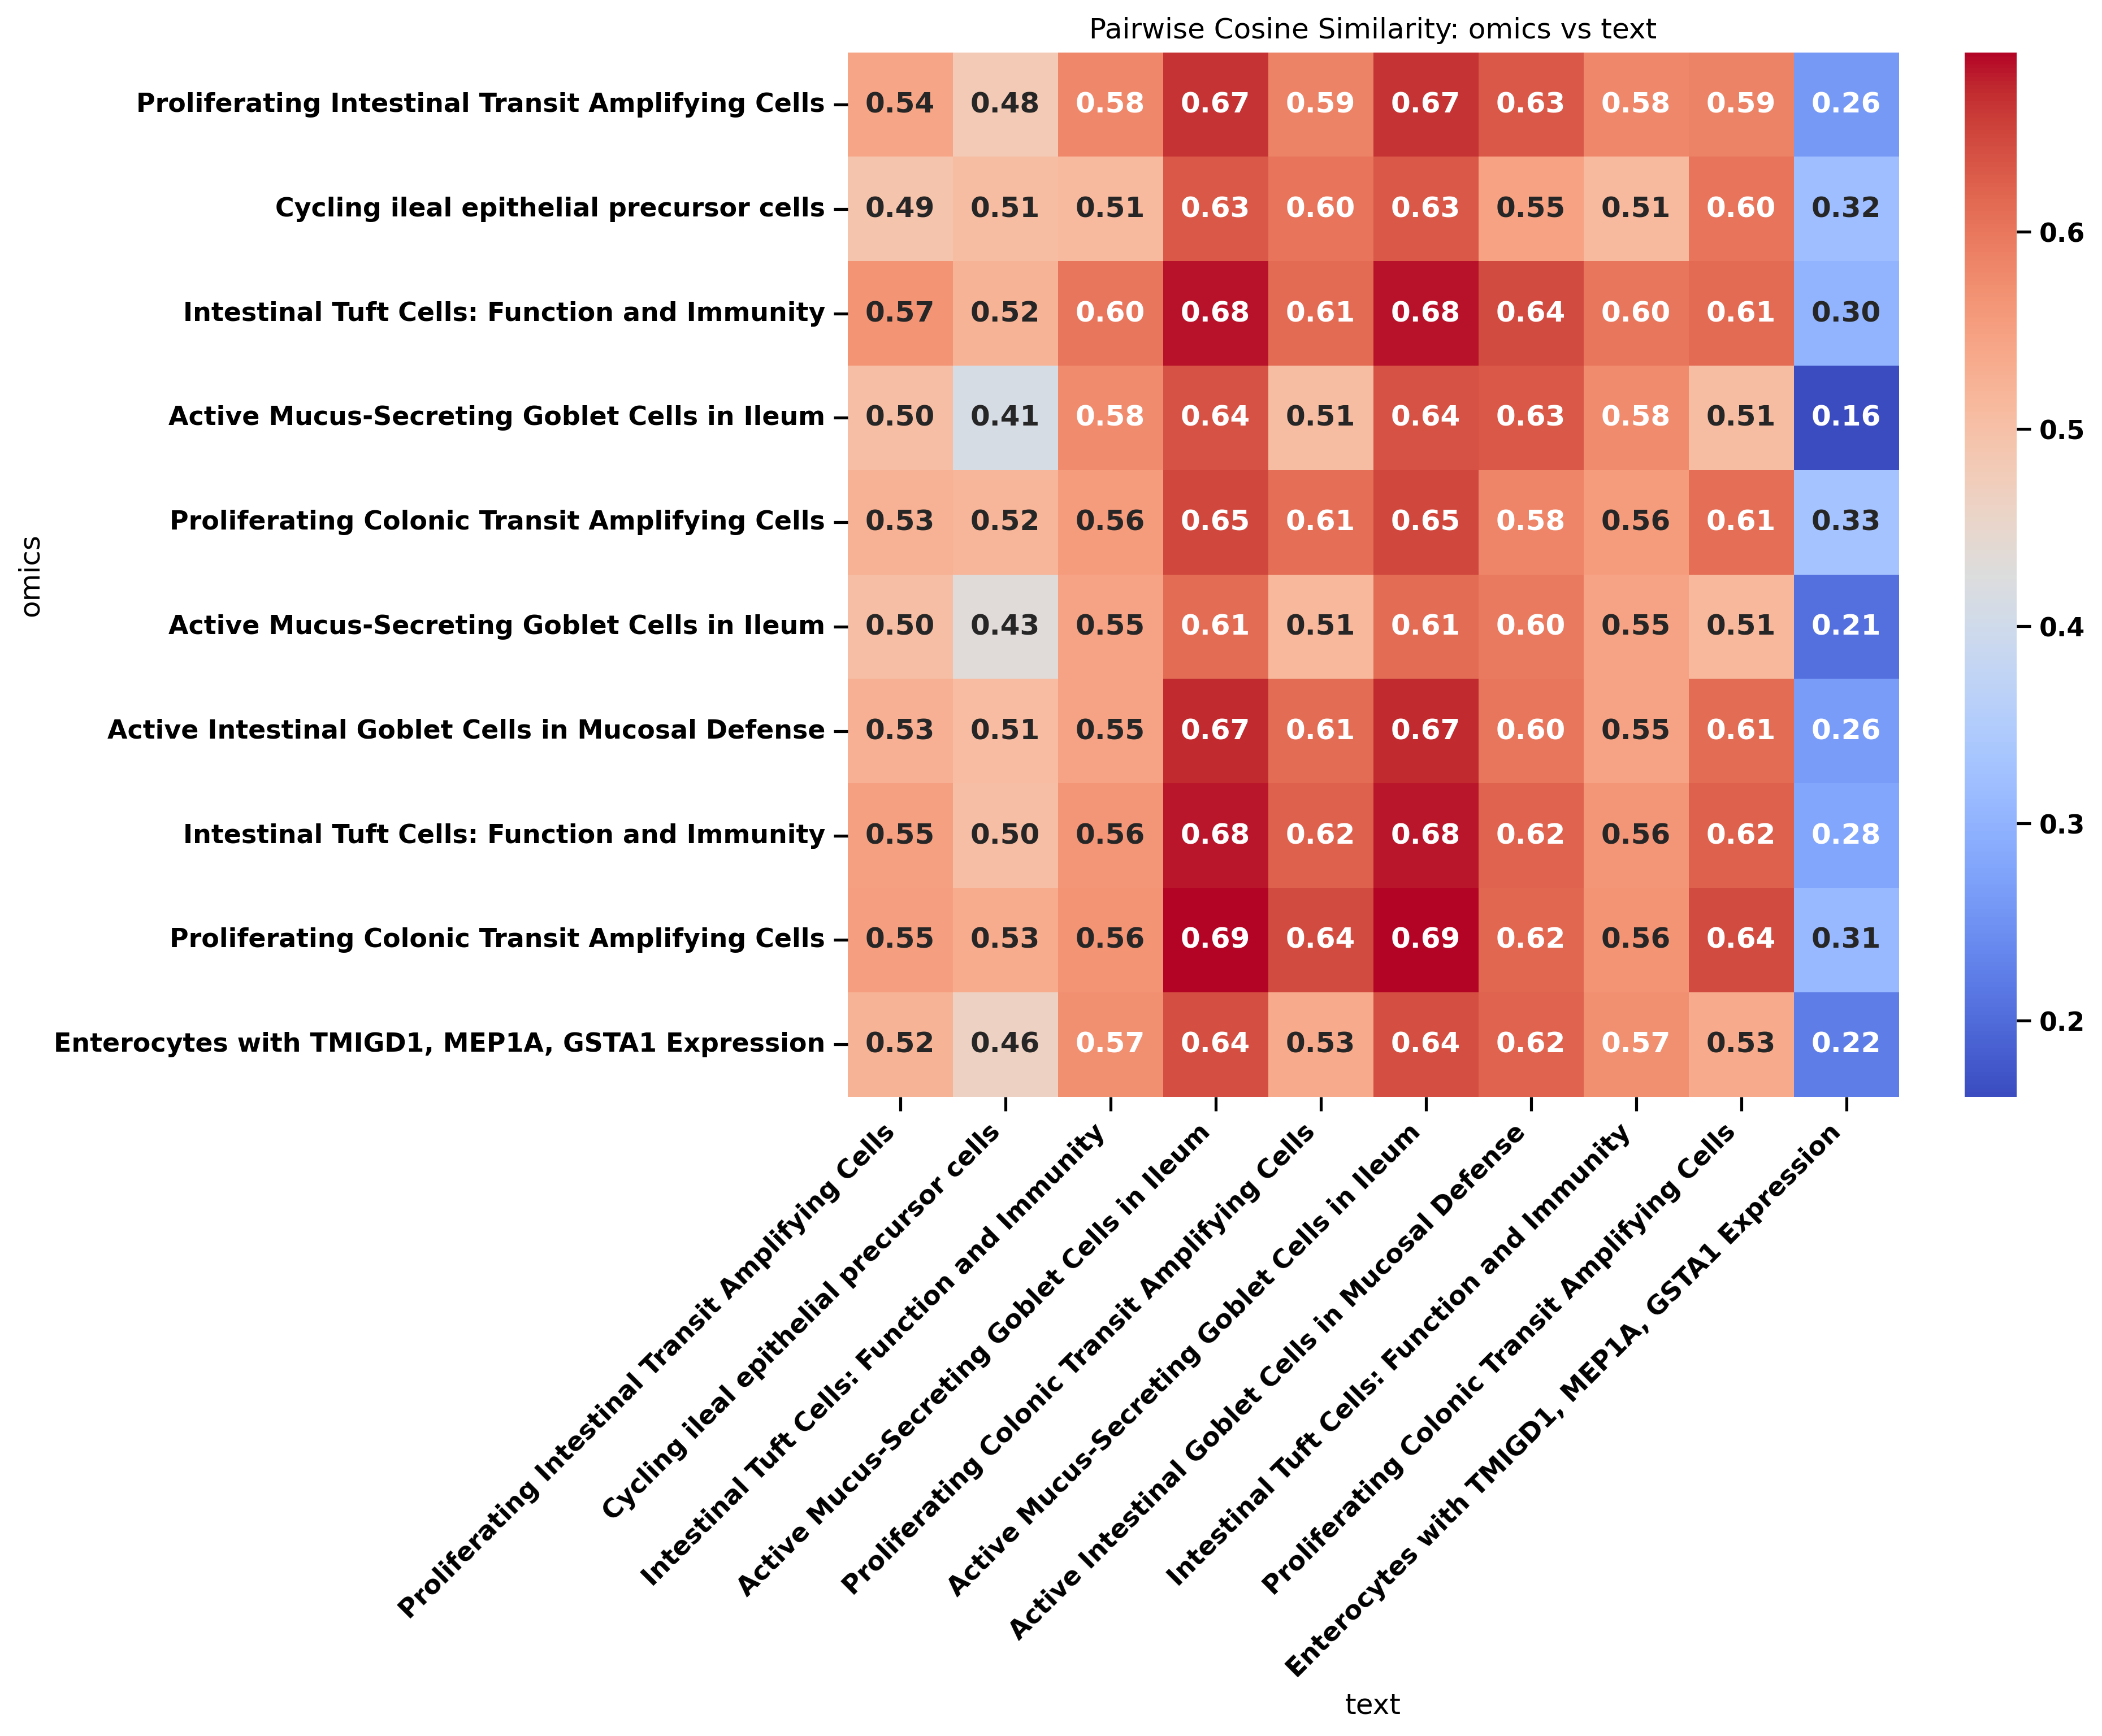

In [166]:
logger.info("Plot embedding similarity with subset=10...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=10, label_key=BATCH_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset10_batch.png", dpi=150)
    logger.info("Similarity plot (subset=10, batch) saved.")

logger.info("Plot embedding similarity with subset=10 using cell_type...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=10, label_key=LABEL_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset10_celltype.png", dpi=150)
    logger.info("Similarity plot (subset=10, cell_type) saved.")

If you want a larger subset for the similarity visualization (e.g., 200 samples):

2025-03-06 12:54:01,168 - root - INFO - Plot embedding similarity with subset=200...


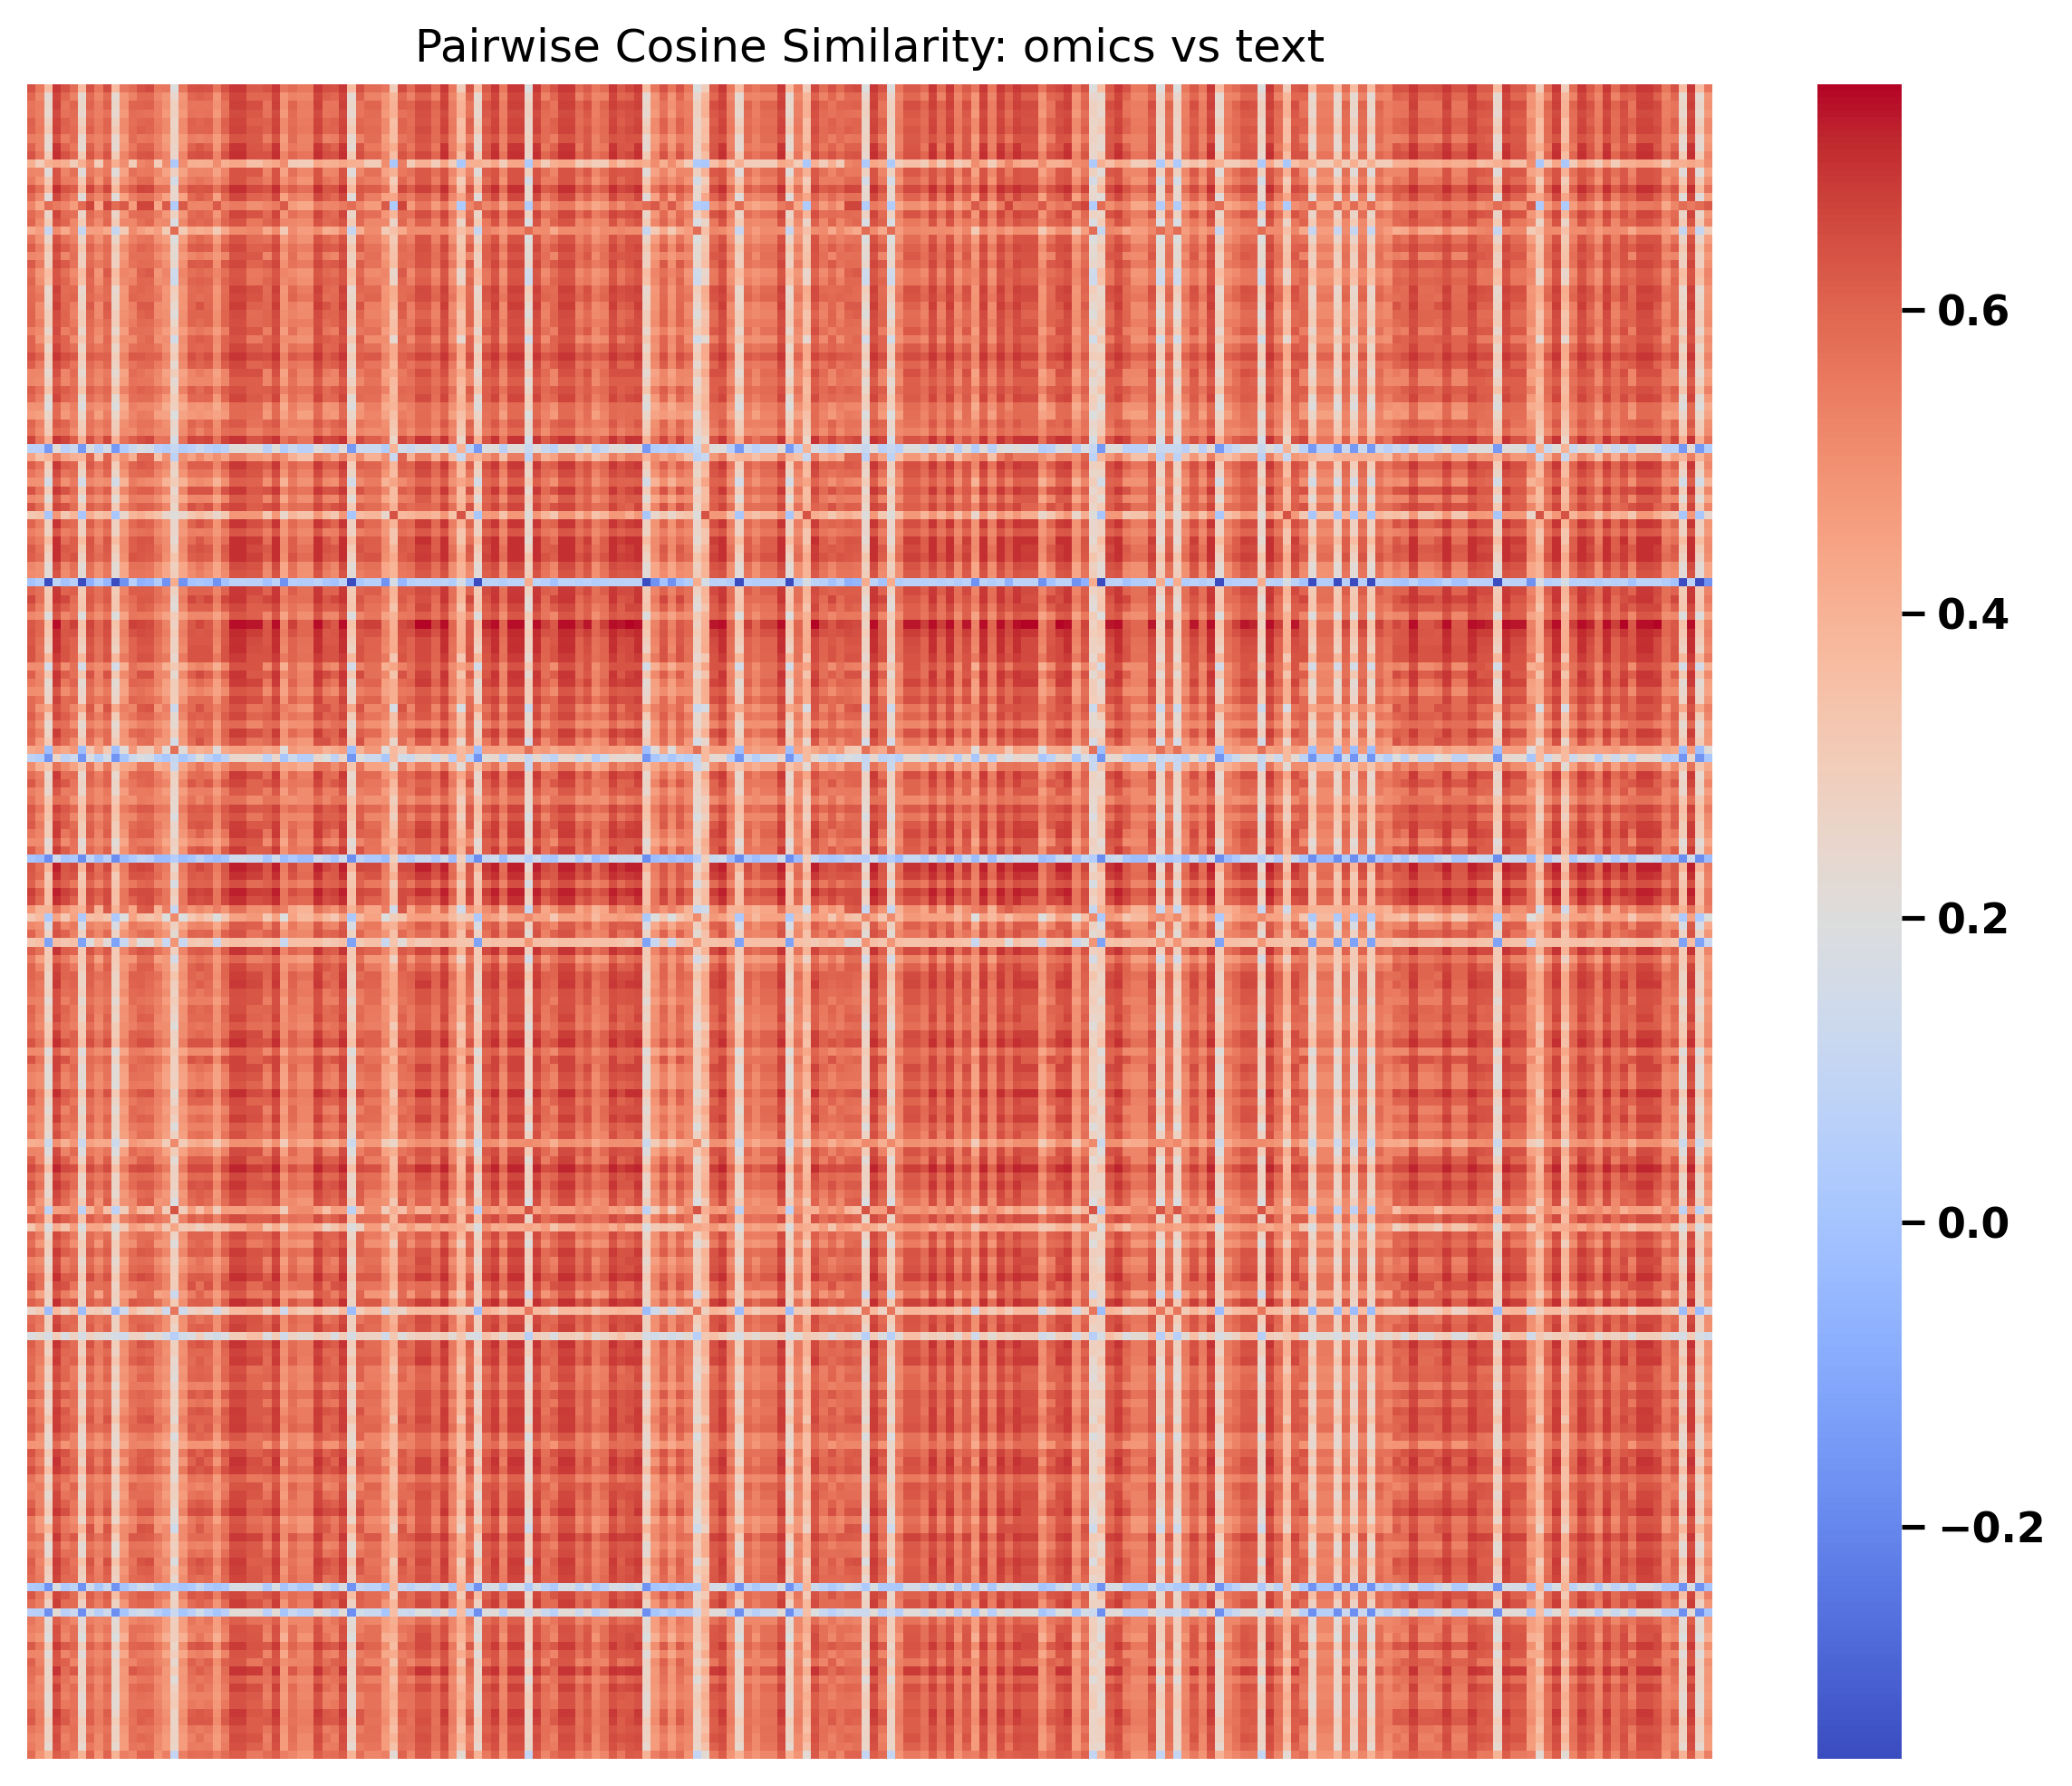

In [154]:
# Example: subset of 200
logger.info("Plot embedding similarity with subset=200...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=200, label_key=LABEL_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset200_celltype.png", dpi=150)
    logger.info("Similarity plot (subset=200, cell_type) saved.")

## 6. scibEvaluator

We can use scibEvaluator for evaluating batch integration and bio-conservation metrics (Luecken et al.).

In [167]:
EMBEDDING_KEYS.append("transcriptome_embeds")

In [17]:
# from mmcontext.pp.utils import remove_zero_variance_cells, remove_zero_variance_genes
# adata = remove_zero_variance_genes(adata)
# adata = remove_zero_variance_cells(adata)

In [1]:
logger.info("Initializing scibEvaluator...")
evaluator = scibEvaluator(
    adata=adata,
    batch_key=BATCH_KEY,
    label_key=LABEL_KEY,
    embedding_key=EMBEDDING_KEYS,
    n_top_genes=5000,
    max_cells=5000,
    in_parallel=False,
)

logger.info("Running scibEvaluator...")
res = evaluator.evaluate()
res_df = pd.DataFrame(res)
res_df

NameError: name 'logger' is not defined

2025-03-06 13:40:25,251 - mmcontext.pl.plotting - INFO - Generating grouped bar chart with metrics on x-axis and type categories as color groups.


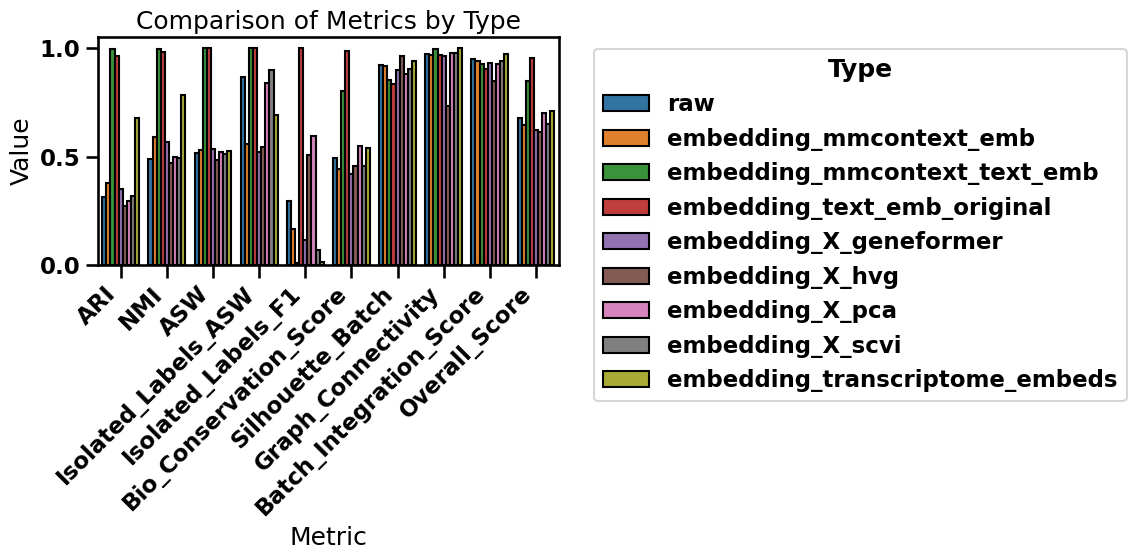

2025-03-06 13:40:25,424 - mmcontext.pl.plotting - INFO - Displayed grouped bar chart interactively.


In [169]:
plot_grouped_bar_chart(res_df)

## 7. Annotation and Query

We can annotate and query our omics data using `OmicsQueryAnnotator`.

2025-03-06 14:31:46,818 - root - INFO - Annotating omics data...
2025-03-06 14:31:46,831 - mmcontext.engine.query_annotate - INFO - Using matrix multiplication to compute label similarities.
Batches: 100%|██████████| 350/350 [00:05<00:00, 61.93it/s]
2025-03-06 14:31:52,523 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-03-06 14:31:52,523 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-03-06 14:31:52,532 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-03-06 14:31:58,472 - root - INFO - Plotting annotated data...
2025-03-06 14:31:58,473 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-03-06 14:31:58,473 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.
... storing 'best_label' as categorical


<Figure size 800x800 with 0 Axes>

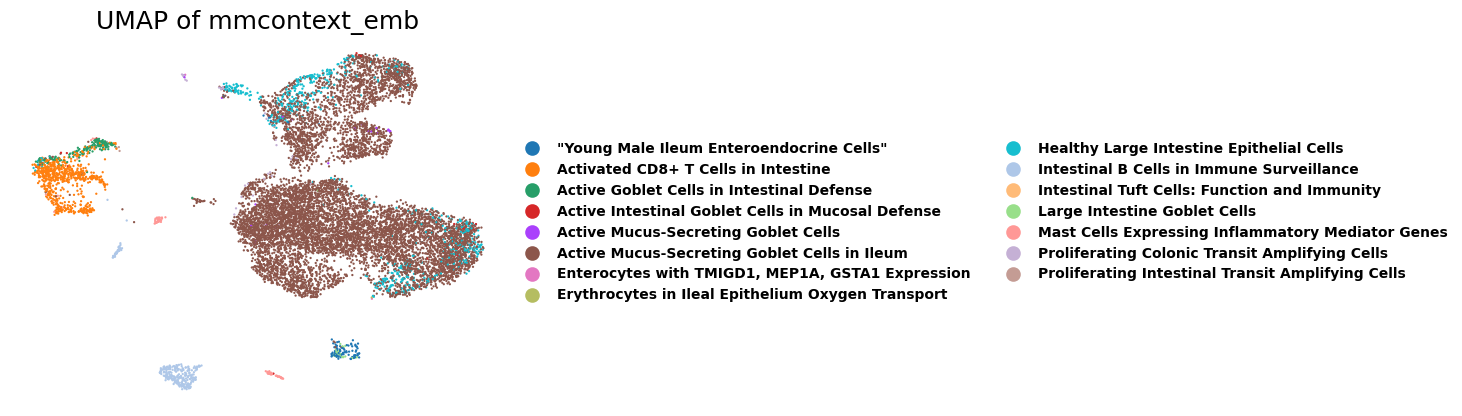

2025-03-06 14:32:03,745 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.
2025-03-06 14:32:03,745 - root - INFO - Evaluating annotation accuracy...
2025-03-06 14:32:03,746 - mmcontext.eval.annotation_accuracy - INFO - Evaluating annotation accuracy for keys 'cluster_label' and 'best_label'. Accuracy = 21.83%
2025-03-06 14:32:03,746 - root - INFO - Accuracy of annotation: 0.21834451901565996


In [23]:
logger.info("Annotating omics data...")
annotator = OmicsQueryAnnotator(model)

# Suppose we have some labels to annotate, e.g. from an external source
labels = adata.obs[LABEL_KEY].values.tolist()
annotator.annotate_omics_data(adata, labels, text_template=ZERO_SHOT_TEXT_TEMPLATE)

logger.info("Plotting annotated data...")
plot_umap(adata, color_key="best_label", embedding_key="mmcontext_emb")

logger.info("Evaluating annotation accuracy...")
score = evaluate_annotation_accuracy(
    adata,
    true_key=LABEL_KEY,  # or whichever key is ground truth for your scenario
    inferred_key="best_label",
)
logger.info(f"Accuracy of annotation: {score}")

### Example: Query with text
You can query the dataset with text prompts and then visualize the result.

2025-03-10 15:12:36,563 - root - INFO - Annotating omics data...
2025-03-10 15:12:36,563 - mmcontext.engine.query_annotate - INFO - Encoding the queries.
Batches: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]
2025-03-10 15:12:36,735 - mmcontext.engine.query_annotate - INFO - Computing similarity between queries and omics data.
2025-03-10 15:12:37,140 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-03-10 15:12:37,141 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


<Figure size 800x800 with 0 Axes>

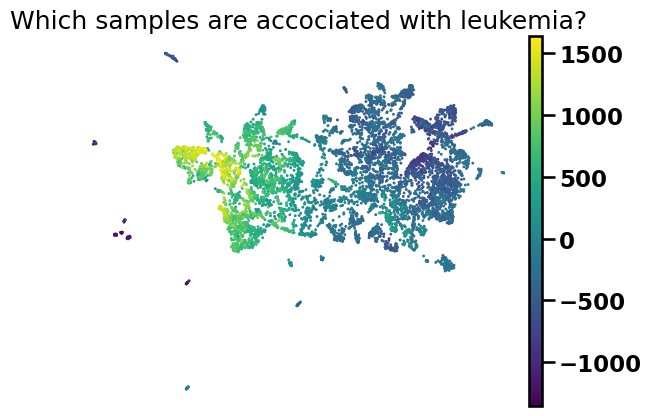

2025-03-10 15:12:43,119 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [54]:
# Example usage
logger.info("Annotating omics data...")
annotator = OmicsQueryAnnotator(model, is_cosine=False)
qa = annotator  # if the OmicsQueryAnnotator has a method query_with_text
# logger.info("Querying dataset for 'This is a immune cell'...")
query = "Which samples are accociated with leukemia?"
qa.query_with_text(adata, [query])

# Visualize
plot_query_scores_umap(adata, embedding_key="mmcontext_emb")
if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("query_scores_umap.png", dpi=150)
    logger.info("Query scores UMAP saved.")

In [42]:
ensemble_id = "ENSG00000107758"
if ensemble_id in adata.var["ensembl_id"]:
    adata.obs[f"{ensemble_id}_expression"] = adata.X[:, adata.var["ensembl_id"] == ensemble_id]
else:
    logger.info(f"{ensemble_id} not found in adata.var['ensembl_id']")

In [46]:
gene_name = "IL6"
if gene_name in adata.var["gene_name"]:
    adata.obs[f"{gene_name}_expression"] = adata.X[:, adata.var["gene_name"] == gene_name]
else:
    logger.info(f"Gene {gene_name} not found in dataset.")

In [48]:
logger.info("Consolidating low-frequency categories...")
# The color_key can be changed to anything in adata.obs, e.g. BATCH_KEY or LABEL_KEY.
color_key = f"{gene_name}_expression"

logger.info("Plotting UMAP...")
plot_umap(
    adata,
    color_key=color_key,
    embedding_key="mmcontext_emb",
    title="",
    legend_loc=None,
    save_plot=False,
    save_format="svg",
    save_dir=".",
)

2025-03-10 14:56:00,562 - root - INFO - Consolidating low-frequency categories...
2025-03-10 14:56:00,563 - root - INFO - Plotting UMAP...
2025-03-10 14:56:00,563 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-03-10 14:56:00,564 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


KeyboardInterrupt: 

In [55]:
from mmcontext.eval.utils import subset_adata_by_query_score

top_adata, bottom_adata = subset_adata_by_query_score(
    adata=adata,
    query_key=query,
    percentile=10.0,  # e.g., top 10% vs bottom 10%
)

print("Top subset shape:", top_adata.shape)
print("Bottom subset shape:", bottom_adata.shape)

2025-03-10 15:12:43,227 - mmcontext.eval.utils - INFO - Splitting data by 'Which samples are accociated with leukemia?' scores at the 10.0th/(90.0th) percentile. Found 700 cells in bottom subset, 700 cells in top subset.


Top subset shape: (700, 67125)
Bottom subset shape: (700, 67125)


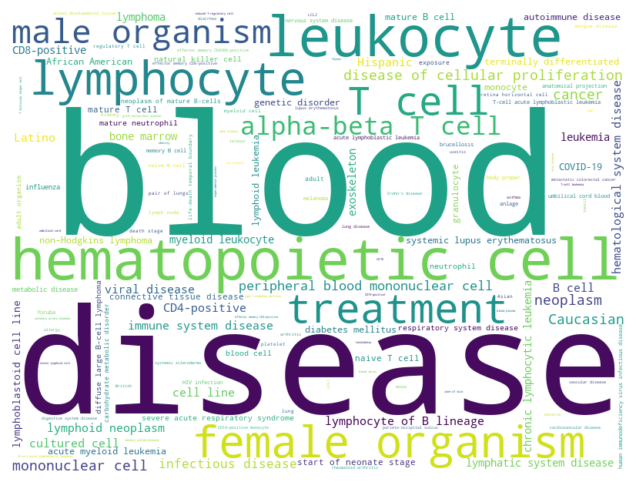

In [56]:
from mmcontext.pl.plotting import plot_wordcloud

plot_wordcloud(top_adata.obs["mapped_ontology_terms"])

Investigate Enrichment of Genes for respondant cells

## 8. Zero-Shot Classification ROC

Below is a function to compute a ROC-AUC for cell-type prediction (or any label) in a zero-shot manner.

In [27]:
logger.info("Computing zero-shot classification ROC...")
macro_auc, auc_details = zero_shot_classification_roc(
    adata,
    model,
    label_key=ZERO_SHOT_LABEL_KEY,
    emb_key=ZERO_SHOT_EMB_KEY,
    text_template="{}",
    device="cpu",
)
logger.info(f"Macro AUC: {macro_auc}")
logger.info(f"Detail per label: {auc_details}")

2025-03-04 16:03:13,647 - root - INFO - Computing zero-shot classification ROC...
2025-03-04 16:03:13,649 - mmcontext.eval.classification_roc - INFO - Building text queries for each label...
2025-03-04 16:03:13,650 - mmcontext.eval.classification_roc - INFO - Embedding 16 label queries...
Batches: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]
2025-03-04 16:03:13,732 - mmcontext.eval.classification_roc - INFO - Retrieving sample embeddings from adata.obsm[mmcontext_emb]...
2025-03-04 16:03:13,733 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-03-04 16:03:13,733 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-03-04 16:03:13,736 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-03-04 16:03:13,770 - mmcontext.eval.classification_roc - INFO - Zero-shot cell-type prediction macro-AUC: 0.7000
2025-03-04 16:03:13,770 - root - INFO - Macro AUC: 0.6999906753071574
2025-03-04 16:03:13,771 - root - INFO - Deta

## 9. (Optional) Saving Notebook Outputs

If you wish to programmatically save this notebook (e.g., for batch runs or CI/CD), you can use a dedicated library like `nbformat` or `papermill`. Here's a small snippet as an example (commented out by default).

In [ ]:
# Uncomment and adapt if you want to save the executed notebook programmatically
# import nbformat
# from nbformat.v4 import new_notebook
# from nbconvert.preprocessors import ExecutePreprocessor
# from nbconvert import HTMLExporter
#
# if SAVE_RESULTS:
#     logger.info("Saving notebook...")
#     with open("evaluation_notebook.ipynb", "r") as f:
#         nb = nbformat.read(f, as_version=4)
#     ep = ExecutePreprocessor(timeout=600)
#     ep.preprocess(nb, {'metadata': {'path': './'}})
#     with open("evaluation_notebook_executed.ipynb", "w") as f:
#         nbformat.write(nb, f)
#
#     # Optionally export to HTML
#     html_exporter = HTMLExporter()
#     body, _ = html_exporter.from_notebook_node(nb)
#     with open("evaluation_notebook_executed.html", "w") as f:
#         f.write(body)
#
#     logger.info("Notebook saved as evaluation_notebook_executed.ipynb and HTML version.")
